## Introduction to Compressed Sensing

### Simple problem

$x$ is a $3$-sparse vector of size $100$ and $A$ is a random binary sampling matrix of size $M \times N$. Given $y = Ax$, we estimate $x$ with 

$$\hat{x} = \arg\min_x \| y - Ax \|_2^2 + \gamma \| x \|_1$$

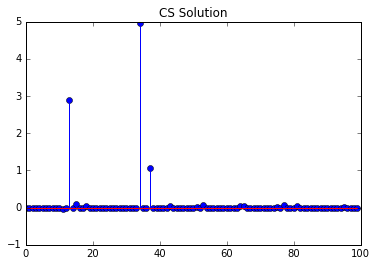

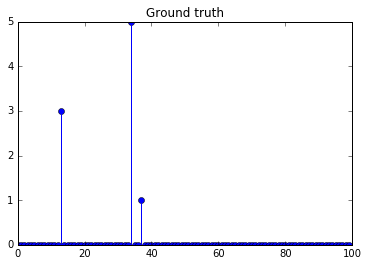

In [1]:
import numpy as np
from cvxpy import *
import matplotlib.pyplot as plt
%matplotlib inline

M = 30
N = 100

#define a sparse vector
x = np.zeros(N)
x[13] = 3
x[34] = 5
x[37] = 1

#define a random matrix
A = np.random.randint(0,2, [M, N])

#compute y
y = np.dot(A, x)

#add noise (comment it if you want the noiseless case)
sigma = 0.5
y += sigma*np.random.random(M)

# gamma must be positive due to DCP rules.
gamma = 1

# Construct the problem.
x_hat = Variable(N)
error = sum_squares(A*x_hat - y)
obj = Minimize(error + gamma*norm(x_hat, 1))
prob = Problem(obj)

prob.solve()

#plot solution
plt.figure()
plt.stem(x_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(x)
plt.title('Ground truth')
plt.show()

### Sparsity in the wavelet domain

Often, the vector $x$ is not sparse in the primal domain, but could be sparse in a different domain. For instance, it is well-known that images are spare in the wavelet domain.

$$x = W^T \alpha$$

where $W$ is an orthonormal basis containing the wavelet basis functions and $\alpha$ is the sparse vector of wavelet coefficients.

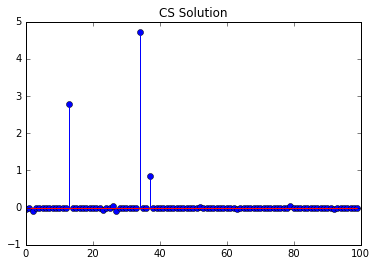

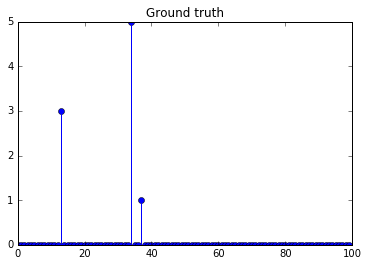

In [2]:
import scipy as sp

M = 30
N = 100

#define a sparse vector
alpha = np.zeros(N)
alpha[13] = 3
alpha[34] = 5
alpha[37] = 1

#generate a random orthonormal matrix
W = sp.linalg.orth(np.random.random([N,N]))

#define a random sampling matrix
A = np.random.randint(0,2, [M, N])
B = np.dot(A, W)

#compute y = AWalpha
y = np.dot(B, alpha)

#add noise (comment it if you want the noiseless case)
sigma = 0.5
y += sigma*np.random.random(M)

# gamma must be positive due to DCP rules.
gamma = 1

# Construct the problem.
alpha_hat = Variable(N)
error = sum_squares(B*alpha_hat - y)
obj = Minimize(error + gamma*norm(alpha_hat, 1))
prob = Problem(obj)

prob.solve()

#plot solution
plt.figure()
plt.stem(alpha_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(alpha)
plt.title('Ground truth')
plt.show()


## Helpful functions

In [159]:
from scipy.stats import multivariate_normal

def haar(n):
    h = [1]
    if n > 2:
        h = haar(n/2)

    #calculate upper haar part
    h_n = np.kron(h, [1,1])
    
    #calculate lower haar part
    if len(h) < 2:
        h_i = np.kron([1], [1,-1]) 
    else:
        h_i = np.kron(np.eye(len(h)), [1,-1]) 
    
    #combine parts
    h = np.vstack([h_n, h_i])
    return h/np.sqrt(2)


def compute_2D_wavelet_matrix(n, db_number=1):
    
    n2 = n**2
    
    ident = np.eye(n2)
    wavedec2, waverec2 = ag.util.wavelet.daubechies_factory((n, n), 'db' + str(db_number))
    
    mat = np.zeros([n2, n2])
    mat_inv = np.zeros([n2, n2])
    
    for k in range(n2):
        ek = ident[k,:]
        
        mat[:,k]     = wavedec2(ek.reshape([n,n])).flatten()
        mat_inv[:,k] = waverec2(ek.reshape([n,n])).flatten()
            
    return mat, mat_inv


def sampling_matrix(N, K):
    N2 = N**2
    L  = K*N2
    A = np.zeros([N2, K*N2])
    for k in range(N2):
        A[k, (N2*k+k)%L] = 1

    return A

def random_sampling_matrix(N, K):
    N2 = N**2
    L  = K*N2
    A = np.zeros([N2, K*N2])
    
    for k in range(N2):
        A[k, N2*np.random.randint(K) + k] = 1
        
    return A

def generate_images(path, N, K, phi, display=False):
    
    diffuse = io.imread(path)
    diffuse = color.rgb2gray(diffuse)

    specular = np.zeros([N,N])
    specular[N//2:, N//2:] = 1
    
    s1, s2 = diffuse.shape
    
    x, y = np.meshgrid(np.linspace(0,1,s1), np.linspace(0,1,s2))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multivariate_normal([0.5, 0.4], 0.1*np.array([[0.5, 0.1], [0.1, 0.3]]))
    specular =  rv.pdf(pos)
    specular/= np.max(specular) #normalize
    
    shifts = np.linspace(0, np.pi-np.pi/4, K)
    images = np.zeros([K, N, N])

    for k, shift in enumerate(shifts):

        #make sure we clip the specularity and maintain the same exposure level
        image = np.minimum(diffuse + specular*(np.cos(phi+shift))**2, 1)
        images[k,:,:] = image
        
        if display:
            plt.figure()
            plt.imshow(image, cmap='gray', interpolation='none')
            plt.axis('off');
        
    return images, diffuse, specular

def generate_images_from_alpha(N, K, phi, alpha_d, alpha_s, W, display=False):
    
    diffuse  = np.dot(W, alpha_d).reshape([N, N])
    specular = np.dot(W, alpha_s).reshape([N, N])

    shifts = np.linspace(0, np.pi-np.pi/4, K)
    images = np.zeros([K, N, N])

    for k, shift in enumerate(shifts):

        #make sure we clip the specularity and maintain the same exposure level
        image = np.minimum(diffuse + specular*(np.cos(phi+shift))**2, 1)
        images[k,:,:] = image
        
        if display:
            plt.figure()
            plt.imshow(image, cmap='gray', interpolation='none')
            plt.axis('off');
        
    return images, diffuse, specular

def compute_C(N, K, phi):
    
    shifts = np.linspace(0, np.pi-np.pi/4, K)
    
    C = []
    for k, shift in enumerate(shifts):
        if len(C) == 0:
            C = np.hstack([ np.eye(N**2), np.cos(phi+shift)**2*np.eye(N**2) ])
        else:
            Cnew = np.hstack([ np.eye(N**2), np.cos(phi+shift)**2*np.eye(N**2) ])
            C    = np.vstack([C, Cnew])
            
    return C
                
#print(haar(8))

#images, diffuse, specular, = generate_images('images/original_64_64.png', N, K, phi, display=True)

# Wavelet basis $\ell_1$ minimization

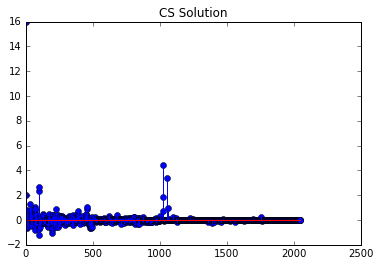

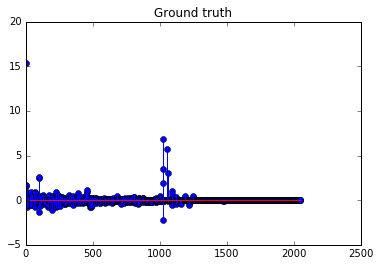

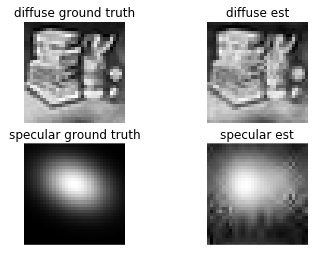

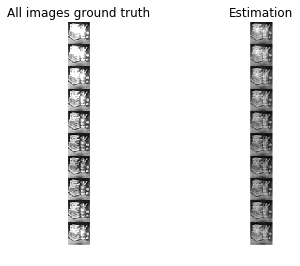

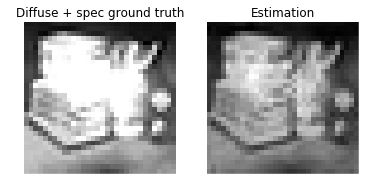

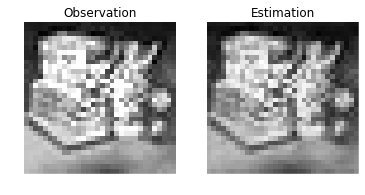

In [158]:
import scipy as sp
import pywt

K  = 10
N  = 32
N2 = N**2
phi = 0.0

#generate a Haar matrix
W = haar(N2)
W, W_inv = compute_2D_wavelet_matrix(N, db_number=9)

#define the sampling matrix
A = sampling_matrix(N, K)
#B = np.dot(A, np.tile(W, [K ,1]))
B = np.dot(A, np.kron(np.eye(K), W))

#compute y = A*x
images, diffuse, spec = generate_images('images/original_'+ str(N) + '_' + str(N) + '.png', N, K, phi)
x       = images.flatten()
alpha_d = W @ diffuse.flatten()
alpha_s = W @ spec.flatten()

#make sure we are sparse in the wavelet domain
#alpha_d = np.zeros(N2)
#alpha_s = np.zeros(N2)

#alpha_d[12] = 2
#alpha_d[120] = 4
#alpha_d[587] = 0.5
#alpha_d[286] = 6
#alpha_s[121] = 3
#alpha_s[985] = 5
#alpha_s[101] = 1

#images, diffuse, spec = generate_images_from_alpha(N, K, phi, alpha_d, alpha_s, W)

alpha = np.hstack([alpha_d, alpha_s])

#measurements
y = np.dot(A, x)

#model matrix
C = compute_C(N, K, 0)
S = A @ C @ np.kron(np.eye(2), W_inv)

#add noise (comment it if you want the noiseless case)
#sigma = 0.1
#y += sigma*np.random.random(len(y))

# gamma must be positive
gamma = 0.1

# Construct the problem
alpha_hat = Variable(2*N2)
error = sum_squares(S @ alpha_hat - y)
obj = Minimize(error + gamma*norm(alpha_hat, 1))
prob = Problem(obj)

#obj = Minimize(error)
#constraints = [y == S @ alpha_hat]
#prob = Problem(obj, constraints)

prob.solve(solver=SCS)

#plot solution
plt.figure()
plt.stem(alpha_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(alpha) 
plt.title('Ground truth')
plt.show()

diffuse_hat = np.reshape(W_inv @ alpha_hat.value[:N2], [N, N])
spec_hat = np.reshape(W_inv @ alpha_hat.value[N2:], [N, N])

x_hat = C @ np.kron(np.eye(2), W_inv) @ alpha_hat.value
y_hat = S @ alpha_hat.value

#plot all the images 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.imshow(diffuse, cmap='gray', interpolation='none')
ax1.axis('off')
ax1.set_title('diffuse ground truth')

ax2.imshow(diffuse_hat, cmap='gray', interpolation='none')
#ax2.imshow(y.reshape([K,N,N])[1,:,:], cmap='gray', interpolation='none')
ax2.axis('off');
ax2.set_title('diffuse est')

ax3.imshow(spec, cmap='gray', interpolation='none')
ax3.axis('off');
ax3.set_title('specular ground truth')

ax4.imshow(spec_hat, cmap='gray', interpolation='none')
ax4.axis('off');
ax4.set_title('specular est')

f, (ax5, ax6) = plt.subplots(1, 2)
ax5.imshow(x.reshape([K*N, N]), cmap='gray', interpolation='none')
ax5.axis('off')
ax5.set_title('All images ground truth')

ax6.imshow(x_hat.reshape([K*N, N]), cmap='gray', interpolation='none')
ax6.axis('off')
ax6.set_title('Estimation')

f, (ax7, ax8) = plt.subplots(1, 2)
ax7.imshow(diffuse + spec, cmap='gray', interpolation='none', vmax=1)
ax7.axis('off')
ax7.set_title('Diffuse + spec ground truth')

ax8.imshow(diffuse_hat + spec_hat, cmap='gray', interpolation='none')
ax8.axis('off')
ax8.set_title('Estimation')

f, (ax9, ax10) = plt.subplots(1, 2)
ax9.imshow(y.reshape([N,N]), cmap='gray', interpolation='none', vmax=1)
ax9.axis('off')
ax9.set_title('Observation')

ax10.imshow(y_hat.reshape([N,N]), cmap='gray', interpolation='none')
ax10.axis('off')
ax10.set_title('Estimation')


# TV norm minimization

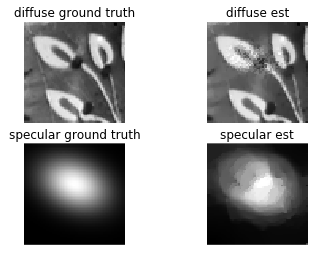

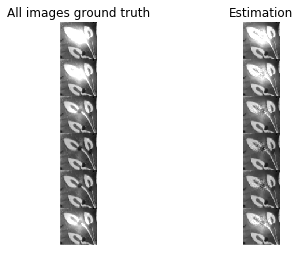

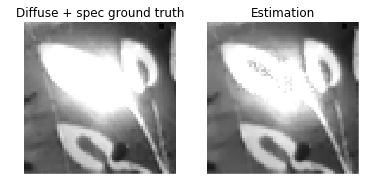

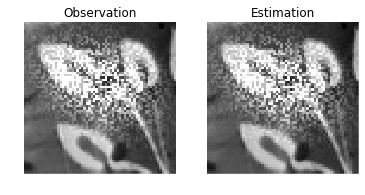

In [179]:
import scipy as sp
import pywt

K  = 6
N  = 64
N2 = N**2
phi = 0.0

#generate a Haar matrix
W = haar(N2)
W, W_inv = compute_2D_wavelet_matrix(N, db_number=8)

#define the sampling matrix
#A = sampling_matrix(N, K)
A = random_sampling_matrix(N, K)
#B = np.dot(A, np.tile(W, [K ,1]))
B = np.dot(A, np.kron(np.eye(K), W))

#compute y = A*x
images, diffuse, spec = generate_images('images/original_'+ str(N) + '_' + str(N) + '_crop.png', N, K, phi)
x       = images.flatten()
alpha_d = W @ diffuse.flatten()
alpha_s = W @ spec.flatten()

#make sure we are sparse in the wavelet domain
#alpha_d = np.zeros(N2)
#alpha_s = np.zeros(N2)

#alpha_d[12] = 2
#alpha_d[120] = 4
#alpha_d[587] = 0.5
#alpha_d[286] = 6
#alpha_s[121] = 3
#alpha_s[985] = 5
#alpha_s[101] = 1

#images, diffuse, spec = generate_images_from_alpha(N, K, phi, alpha_d, alpha_s, W)

im = np.hstack([diffuse.flatten(), spec.flatten()])

#measurements
y = np.dot(A, x)

#model matrix
C = compute_C(N, K, 0)
S = A @ C

#add noise (comment it if you want the noiseless case)
#sigma = 0.1
#y += sigma*np.random.random(len(y))

# gamma must be positive
gamma = 0.02

# Construct the problem
diffuse_hat = Variable(N,N)
spec_hat    = Variable(N,N)

error = sum_squares(S @ vstack( vec(diffuse_hat), vec(spec_hat) ) - y)
obj = Minimize(error + gamma*( tv(diffuse_hat) + tv(spec_hat) ))
#obj = Minimize(error + gamma*( tv(diffuse_hat) + norm(vec(spec_hat),1) ))
constraints = [(spec_hat) >= 0, (diffuse_hat) >= 0, vec(diffuse_hat) <= y]  #non-negativity
prob = Problem(obj, constraints)

prob.solve(solver=SCS)

diffuse_hat = diffuse_hat.value.T
spec_hat = spec_hat.value.T

im_hat = np.hstack([diffuse_hat.flatten(), spec_hat.flatten()]).T

x_hat = C @ im_hat
y_hat = S @ im_hat

#plot all the images 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.imshow(diffuse, cmap='gray', interpolation='none')
ax1.axis('off')
ax1.set_title('diffuse ground truth')

ax2.imshow(diffuse_hat, cmap='gray', interpolation='none')
#ax2.imshow(y.reshape([K,N,N])[1,:,:], cmap='gray', interpolation='none')
ax2.axis('off');
ax2.set_title('diffuse est')

ax3.imshow(spec, cmap='gray', interpolation='none')
ax3.axis('off');
ax3.set_title('specular ground truth')

ax4.imshow(spec_hat, cmap='gray', interpolation='none')
ax4.axis('off');
ax4.set_title('specular est')

f, (ax5, ax6) = plt.subplots(1, 2)
ax5.imshow(x.reshape([K*N, N]), cmap='gray', interpolation='none', vmax=1)
ax5.axis('off')
ax5.set_title('All images ground truth')

ax6.imshow(x_hat.reshape([K*N, N]), cmap='gray', interpolation='none', vmax=1)
ax6.axis('off')
ax6.set_title('Estimation')

f, (ax7, ax8) = plt.subplots(1, 2)
ax7.imshow(diffuse + spec, cmap='gray', interpolation='none', vmax=1)
ax7.axis('off')
ax7.set_title('Diffuse + spec ground truth')

ax8.imshow(diffuse_hat + spec_hat, cmap='gray', interpolation='none', vmax=1)
ax8.axis('off')
ax8.set_title('Estimation')

f, (ax9, ax10) = plt.subplots(1, 2)
ax9.imshow(y.reshape([N,N]), cmap='gray', interpolation='none', vmax=1)
ax9.axis('off')
ax9.set_title('Observation')

ax10.imshow(y_hat.reshape([N,N]), cmap='gray', interpolation='none', vmax=1)
ax10.axis('off')
ax10.set_title('Estimation')
